In [343]:
import numpy as np
from sklearn.preprocessing import normalize
import plotly.express as px
import matplotlib.pyplot as plt

In [344]:
A = np.array([
    [.1, .2, .05, .8, .9, .7, .5, .4, .45],
    [.5, .45, .55, .1, .05, .1, .1, .2, .15],
    [.4, .35, .4, .1, .05, .2, .4, .4, .4]
])

C = np.array([
    [1000, 0, 0],
    [500, 0, 0],
    [2000, 0, 0],
    [0, 500, 0],
    [0, 400, 0],
    [0, 5000, 0],
    [0, 0, 1000],
    [0, 0, 100],
    [0, 0, 500]
])

## Original Matrix

In [345]:
px.imshow(A, width=500)

## Matrix Multiplication

$$I = (C\quad\emptyset\quad\hat{j}C)A$$

In [346]:
C_norm = C / np.array([1 for _ in range(9)]).dot(C)
I = C_norm.dot(A)
px.imshow(I, width=500)

## Iterative Proportional Fitting

Iterate these two steps on P [source](https://www.researchgate.net/publication/336917269_What_is_Iterative_Proportional_Fitting)

$$(1)\quad P_{ij(k+1)}=(\frac{P_{ij(k)}}{\sum_jP_{ij(k)}}) Q_i$$

$$(2)\quad P_{ij(k+2)}=(\frac{P_{ij(k+1)}}{\sum_iP_{ij(k+1)}}) Q_j$$

In [347]:
SEEDER = np.array([
    [1/3, 0, 0],
    [1/3, 0, 0],
    [1/3, 0, 0],
    [0, 1/3, 0],
    [0, 1/3, 0],
    [0, 1/3, 0],
    [0, 0, 1/3],
    [0, 0, 1/3],
    [0, 0, 1/3],
])

SEED = SEEDER.dot(A)
capital_margin = C_norm.sum(axis=1)

The algorithm converges after one iteration because all of the column margins are already equal to the column sums in the SEED matrix. To get more value out of iterations, we would have to have country/sector total capital expenditure values that are considered more reliable.

In [348]:
# column_margin = np.array([1 + np.random.normal(0,.1) for  _ in range(9)])
column_margin = SEED.sum(axis=0)
column_margin

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [349]:

for iter in range(2):

    next_S1 = SEED.copy()
    for i in range(SEED.shape[0]):
        for j in range(SEED.shape[1]):
            next_S1[i,j] = capital_margin[i] * SEED[i,j] / SEED.sum(axis=1)[i]

    next_S2 = next_S1.copy()
    for i in range(SEED.shape[0]):
        for j in range(SEED.shape[1]):
            next_S2[i,j] = column_margin[j] * next_S1[i,j] / next_S1.sum(axis=0)[j]
    
    SEED = next_S2.copy()

Text(0.5, 1.0, 'Iterative Proportional')

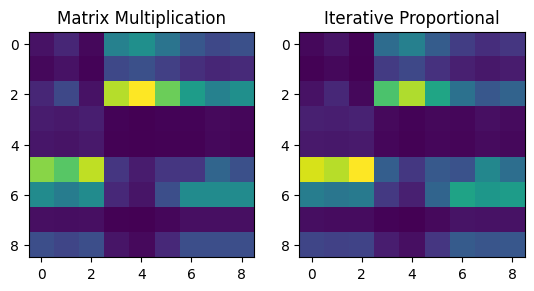

In [350]:
fig, axes = plt.subplots(1,2)

axes[0].imshow(I)
axes[0].set_title("Matrix Multiplication")
axes[1].imshow(SEED)
axes[1].set_title("Iterative Proportional")